In [1]:
import scanpy as sc
import pandas as pd
import os; import re

# plot
import matplotlib.pyplot as plt
import seaborn as sns

# Ref

scanpy:
- [Preprocessing and clustering 3k PBMCs — scanpy-tutorials 1.4.7.dev38+g3e4e434 documentation](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)
- [scanpy.external.pp.harmony_integrate — Scanpy 0.1.0.dev documentation](https://scanpy.readthedocs.io/en/stable/generated/scanpy.external.pp.harmony_integrate.html)

Tutorials:
- [Single-cell best practices — Single-cell best practices](https://www.sc-best-practices.org/preamble.html)
- [single_cell_tutorial Readthedocs](https://single-cell-tutorial.readthedocs.io/zh/latest/)

# Function

In [31]:
def mergeClinicalData(adata, clinical_data, select_col = ["condition", "final_celltype","barcode"], 
                      merge_col = ["barcode"]):
    adata = adata[adata.obs[merge_col].isin(clinical_data[merge_col]), :]
    obs_names = adata.obs_names
    adata.obs = pd.merge(adata.obs, clinical_data[select_col], on=merge_col)
    adata.obs_names = obs_names
    return(adata)

def basicQC(adata):
    # basic filter
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    # mito
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

def normalizeData(adata, log = True, scale = True):
    if(log == True):
        adata.layers["counts"] = adata.X.copy()
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
        adata.layers["logcounts"] = adata.X.copy()
    sc.pp.highly_variable_genes(
    adata, n_top_genes=3000, flavor="seurat" # ,batch_key = "batch"
    )
    if(scale == True):
        # adata.raw = adata
        adata = adata[:, adata.var.highly_variable]
        sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
        sc.pp.scale(adata, max_value=10)
    return(adata)
# adata = adata.raw.to_adata()

def dimensionReduction(adata, batch = "batch"):
    # Umap
    sc.tl.pca(adata, n_comps = 50)
    sc.pp.neighbors(adata, n_neighbors=30)
    sc.tl.umap(adata)
    adata.obsm["X_pca_raw"] = adata.obsm["X_pca"]
    adata.obsm["X_umap_raw"] = adata.obsm["X_umap"]
    # harmony
    sc.external.pp.harmony_integrate(adata, key= batch, basis='X_pca_raw')
    sc.pp.neighbors(adata, use_rep = "X_pca_harmony", n_neighbors=30)
    sc.tl.umap(adata)
    adata.obsm["X_umap_harmony"] = adata.obsm["X_umap"]

def addEmbeddingData(adata, adata_scale):
    adata.obsm["X_umap_raw_scaled"] = adata_scale.obsm["X_umap_raw"]
    adata.obsm["X_umap_harmony_scaled"] = adata_scale.obsm["X_umap_harmony"]
    adata.obsm["X_pca_raw_scaled"] = adata_scale.obsm["X_pca_raw"]
    adata.obsm["X_pca_harmony_scaled"] = adata_scale.obsm["X_pca_harmony"]
    adata.obsm["X_umap_raw_unscaled"] = adata.obsm["X_umap_raw"]
    adata.obsm["X_umap_harmony_unscaled"] = adata.obsm["X_umap_harmony"]
    adata.obsm["X_pca_raw_unscaled"] = adata.obsm["X_pca_raw"]
    adata.obsm["X_pca_harmony_unscaled"] = adata.obsm["X_pca_harmony"]


# Stanford_Li

## Prepare

In [3]:
path = "../../Input/Data/processed_DB/Stanford_Li/gastric_scRNAseq_filtered/"
files = os.listdir(path)
dirs_path = [path + str(i) for i in files]
dirs_path[0]

'../../Input/Data/processed_DB/Stanford_Li/gastric_scRNAseq_filtered/5846_n1'

In [ ]:
adata_list = []
for files in dirs_path:
  adata = sc.read_10x_mtx(
    path = files,
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True  
  )
  adata.obs['batch'] = files.replace(path, "")
  adata.obs['database'] = "Stanford_Li"
  adata_list.append(adata)

In [13]:
adata = sc.concat(adata_list, merge='same')

/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [16]:
adata

AnnData object with n_obs × n_vars = 56167 × 33538
    obs: 'batch', 'database'
    var: 'gene_ids', 'feature_types'

In [15]:
adata.obs['batch'].value_counts()

5931_t1      5861
5931_t2      5356
6709_n1      5237
6592_t1      4804
5846_t1      3476
6342_t1      2976
6207_pbmc    2605
6207_n1      2546
5931_pbmc    2498
5866_t1      2405
6207_t1      2403
5866_n2      2295
5866_t2      2264
6709_t1      1988
5866_n1      1803
6592_n1      1576
5846_n1      1541
6342_n1      1065
5931_n1       926
6649_n1       913
6649_t1       874
5931_n2       755
Name: batch, dtype: int64

Add clinical data

In [5]:
cell_labels = pd.read_csv('../../processed_DB/Stanford_Li/cell_labels.csv')
cell_labels

,cell_barcode,orig.ident,condition,final_celltype,cluster_celltype
0,TCAATCTCAGATCGGA-1,5846_n1,normal,fibroblasts,fibroblasts_2
1,GAACATCTCAAACCGT-5,5866_t1,tumor,fibroblasts,fibroblasts_2
2,GCAGTTACACTGTTAG-9,5931_t1,tumor,fibroblasts,fibroblasts_2
3,AAACCTGAGTGCGTGA-1,5846_n1,normal,fibroblasts,fibroblasts_13
4,AACTCCCAGCTAGGCA-1,5846_n1,normal,fibroblasts,fibroblasts_13
...,...,...,...,...,...
36154,TCGCGAGTCAAACGGG-20,6649_t1,metaplasia,plasma,plasma_7
36155,TCTTTCCTCAGTTCGA-20,6649_t1,metaplasia,plasma,plasma_7
36156,TGAAAGAGTGTGACCC-20,6649_t1,metaplasia,plasma,plasma_7
36157,TGCTGCTAGAAGATTC-20,6649_t1,metaplasia,plasma,plasma_7


In [6]:
cell_labels["final_celltype"].value_counts()

epithelial     9466
CD8            6609
CD4            3307
NK             3207
macrophage     2969
fibroblasts    2761
plasma         2191
endothelial    1701
B              1480
Treg           1399
pericytes       591
mast            391
DC               87
Name: final_celltype, dtype: int64

In [126]:
cell_labels[["orig.ident", "condition"]].value_counts()

orig.ident  condition 
5931_t1     tumor         3673
5931_t2     tumor         3527
6592_t1     tumor         3285
5931_pbmc   pbmc          2438
6207_pbmc   pbmc          2418
6342_t1     tumor         2080
5846_t1     tumor         1995
5866_t1     tumor         1988
6207_t1     tumor         1912
5866_t2     tumor         1835
5866_n2     normal        1774
6709_n1     normal        1617
5866_n1     normal        1379
6207_n1     normal        1298
6709_t1     tumor         1253
6592_n1     normal         761
5931_n1     normal         659
6342_n1     normal         597
5931_n2     normal         523
5846_n1     normal         497
6649_n1     normal         469
6649_t1     metaplasia     181
dtype: int64

In [23]:
adata.obs["barcode"] = list(map(lambda x, y: x[0:16] + ":" + y, adata.obs_names, adata.obs["batch"]))
cell_labels["barcode"] = list(map(lambda x, y: x[0:16] + ":" + y, cell_labels["cell_barcode"], cell_labels["orig.ident"]))

In [25]:
adata = adata[adata.obs["barcode"].isin(cell_labels['barcode']), :]
obs_names = adata.obs_names
adata.obs = pd.merge(adata.obs, cell_labels[["condition", "final_celltype","barcode"]], on='barcode')
adata.obs_names = obs_names
adata.obs

/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


,batch,database,barcode,condition,final_celltype
AAACCTGAGTGCGTGA-1,5846_n1,Stanford_Li,AAACCTGAGTGCGTGA:5846_n1,normal,fibroblasts
AAACGGGAGCTGCCCA-1,5846_n1,Stanford_Li,AAACGGGAGCTGCCCA:5846_n1,normal,mast
AAAGATGAGTGGACGT-1,5846_n1,Stanford_Li,AAAGATGAGTGGACGT:5846_n1,normal,CD8
AAAGTAGCACGCCAGT-1,5846_n1,Stanford_Li,AAAGTAGCACGCCAGT:5846_n1,normal,NK
AAATGCCTCTATCCCG-1,5846_n1,Stanford_Li,AAATGCCTCTATCCCG:5846_n1,normal,epithelial
...,...,...,...,...,...
TTTGGTTCACGGATAG-1,6709_t1,Stanford_Li,TTTGGTTCACGGATAG:6709_t1,tumor,fibroblasts
TTTGGTTTCTTGCATT-1,6709_t1,Stanford_Li,TTTGGTTTCTTGCATT:6709_t1,tumor,macrophage
TTTGTCATCCTTTACA-1,6709_t1,Stanford_Li,TTTGTCATCCTTTACA:6709_t1,tumor,endothelial
TTTGTCATCGAACTGT-1,6709_t1,Stanford_Li,TTTGTCATCGAACTGT:6709_t1,tumor,CD8


In [31]:
print("Before :", adata2.n_obs, ", After :", adata.n_obs)

Before : 56167 , After : 36159


## QC check

In [2]:
adata_stanford = sc.read_h5ad("Output/01/adata_stanford.h5ad")

/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [86]:
sc.pp.filter_cells(adata_stanford, min_genes=200)
sc.pp.filter_genes(adata_stanford, min_cells=3)

/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [133]:
adata_stanford.var['mt'] = adata_stanford.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_stanford, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


<Axes: ylabel='value'>

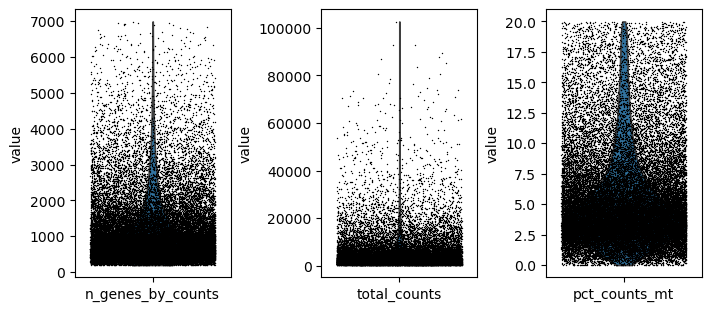

In [134]:
fig, axs = plt.subplots(1, 3, figsize=(7,3),constrained_layout=True)
sc.pl.violin(adata_stanford, ['n_genes_by_counts'], 
             jitter=0.4, ax=axs[0], show=False)
sc.pl.violin(adata_stanford, ['total_counts'],
             jitter=0.4, ax=axs[1], show=False)
sc.pl.violin(adata_stanford, ['pct_counts_mt'],
             jitter=0.4, ax=axs[2], show=False)

In [136]:
adata_stanford.X[1,].toarray().max()

89.0

In [137]:
adata_stanford.layers["counts"] = adata_stanford.X.copy()
sc.pp.normalize_total(adata_stanford, target_sum=1e4)
sc.pp.log1p(adata_stanford)
adata_stanford.layers["logcounts"] = adata_stanford.X.copy()

Check counts distribution:

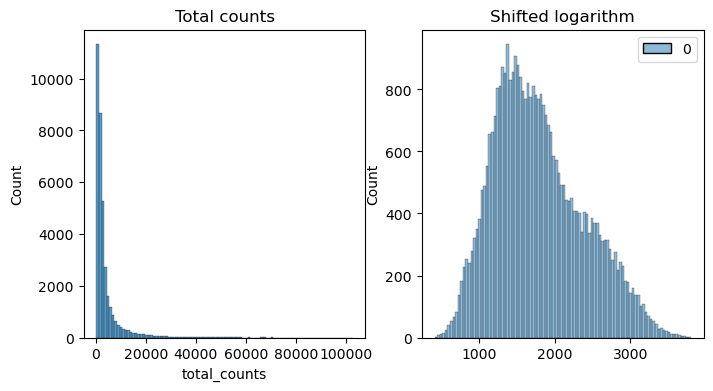

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
p1 = sns.histplot(adata_stanford.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata_stanford.layers["logcounts"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

In [139]:
sc.pp.highly_variable_genes(
    adata_stanford, n_top_genes=3000, batch_key = "batch", flavor="seurat"
)

In [14]:
adata3 = adata_stanford.copy()
adata3 = adata3[:, adata3.var.highly_variable]
sc.pp.regress_out(adata3, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata3, max_value=10)

/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## Batch && Dimension reduction

I would like to investigate the influence of scale.

In [15]:
sc.tl.pca(adata3, n_comps = 50)
sc.pp.neighbors(adata3, n_neighbors=30)
sc.tl.umap(adata3)

In [16]:
adata3.obsm["X_pca_raw"] = adata3.obsm["X_pca"]
adata3.obsm["X_umap_raw"] = adata3.obsm["X_umap"]

In [142]:
sc.tl.pca(adata_stanford, n_comps = 50)
sc.pp.neighbors(adata_stanford, n_neighbors=30)
sc.tl.umap(adata_stanford)

In [146]:
adata_stanford.obsm["X_pca_raw"] = adata_stanford.obsm["X_pca"]
adata_stanford.obsm["X_umap_raw"] = adata_stanford.obsm["X_umap"]

/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Unscaled'}, xlabel='X_umap_raw1', ylabel='X_umap_raw2'>

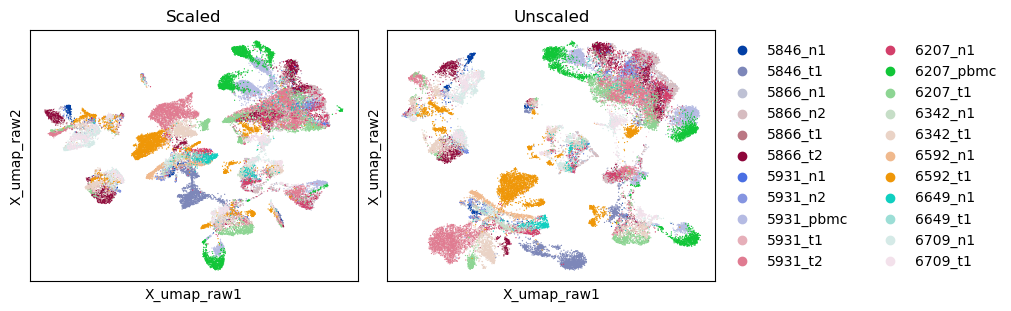

In [216]:
fig, axs = plt.subplots(1, 2, figsize=(10,3),constrained_layout=True)
sc.pl.embedding(adata3, color="batch", basis = "X_umap_raw", title="Scaled", ax=axs[0], show=False, legend_loc = None)
sc.pl.embedding(adata_stanford, color="batch", basis = "X_umap_raw", title="Unscaled", ax=axs[1], show=False)

In [19]:
sc.external.pp.harmony_integrate(adata3, key= "batch", basis='X_pca_raw')

2024-02-20 13:20:16,145 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-02-20 13:20:30,646 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-02-20 13:20:30,864 - harmonypy - INFO - Iteration 1 of 10
2024-02-20 13:20:43,279 - harmonypy - INFO - Iteration 2 of 10
2024-02-20 13:20:55,754 - harmonypy - INFO - Iteration 3 of 10
2024-02-20 13:21:08,052 - harmonypy - INFO - Iteration 4 of 10
2024-02-20 13:21:20,278 - harmonypy - INFO - Iteration 5 of 10
2024-02-20 13:21:32,687 - harmonypy - INFO - Iteration 6 of 10
2024-02-20 13:21:40,698 - harmonypy - INFO - Iteration 7 of 10
2024-02-20 13:21:48,657 - harmonypy - INFO - Iteration 8 of 10
2024-02-20 13:21:55,762 - harmonypy - INFO - Iteration 9 of 10
2024-02-20 13:22:02,277 - harmonypy - INFO - Converged after 9 iterations


In [33]:
sc.pp.neighbors(adata3, use_rep = "X_pca_harmony", n_neighbors=30)
sc.tl.umap(adata3)

In [ ]:
sc.external.pp.harmony_integrate(adata_stanford, key= "batch", basis='X_pca_raw')

In [151]:
sc.pp.neighbors(adata_stanford, use_rep = "X_pca_harmony", n_neighbors=30)
sc.tl.umap(adata_stanford)

In [227]:
adata3.obsm["X_umap_harmony"] = adata3.obsm["X_umap"]
adata_stanford.obsm["X_umap_harmony"] = adata_stanford.obsm["X_umap"]

/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Unscaled'}, xlabel='X_umap_harmony1', ylabel='X_umap_harmony2'>

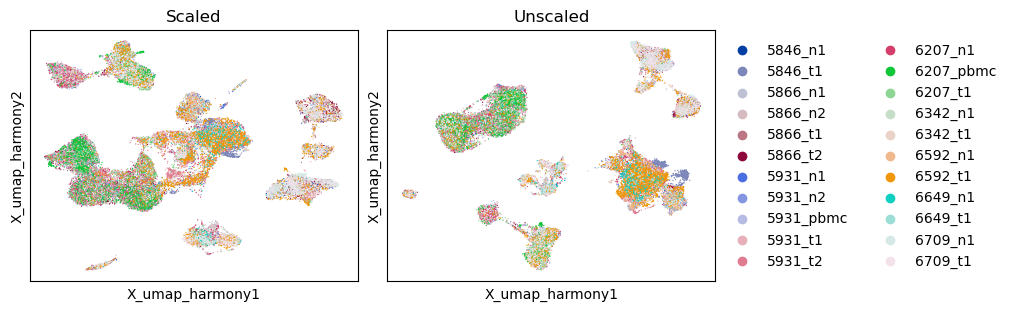

In [228]:
fig, axs = plt.subplots(1, 2, figsize=(10,3),constrained_layout=True)
sc.pl.embedding(adata3, color="batch", basis = "X_umap_harmony", title="Scaled", ax=axs[0], show=False, legend_loc = None)
sc.pl.embedding(adata_stanford, color="batch", basis = "X_umap_harmony", title="Unscaled", ax=axs[1], show=False)


/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Unscaled'}, xlabel='X_umap_harmony1', ylabel='X_umap_harmony2'>

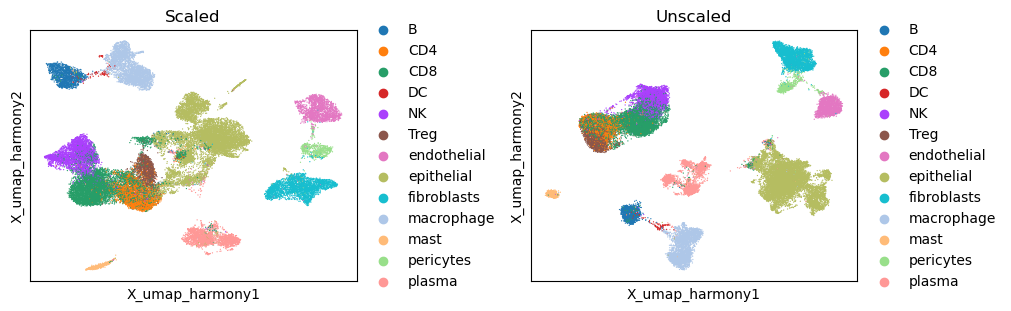

In [229]:
fig, axs = plt.subplots(1, 2, figsize=(10,3),constrained_layout=True)
sc.pl.embedding(adata3, color="final_celltype", basis = "X_umap_harmony", title="Scaled", ax=axs[0], show=False)
sc.pl.embedding(adata_stanford, color="final_celltype", basis = "X_umap_harmony", title="Unscaled", ax=axs[1], show=False)


## Save

In [21]:
adata3

AnnData object with n_obs × n_vars = 36159 × 3000
    obs: 'batch', 'database', 'barcode', 'condition', 'final_celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'batch_colors', 'final_celltype_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_raw', 'X_umap', 'X_umap_harmony', 'X_umap_raw', 'X_umap_scaled_harmony', 'X_umap_scaled_raw'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'connectivities', 'distances'

In [35]:
adata_stanford.obsm["X_umap_raw_scaled"] = adata3.obsm["X_umap_raw"]
adata_stanford.obsm["X_umap_harmony_scaled"] = adata3.obsm["X_umap_harmony"]
adata_stanford.obsm["X_pca_raw_scaled"] = adata3.obsm["X_pca_raw"]
adata_stanford.obsm["X_pca_harmony_scaled"] = adata3.obsm["X_pca_harmony"]

In [23]:
adata_stanford.obsm["X_umap_raw_unscaled"] = adata_stanford.obsm["X_umap_raw"]
adata_stanford.obsm["X_umap_harmony_unscaled"] = adata_stanford.obsm["X_umap_harmony"]
adata_stanford.obsm["X_pca_raw_unscaled"] = adata_stanford.obsm["X_pca_raw"]
adata_stanford.obsm["X_pca_harmony_unscaled"] = adata_stanford.obsm["X_pca_harmony"]

In [43]:
adata_stanford.obs['ref_celltype'] = adata_stanford.obs['final_celltype']

In [44]:
adata_stanford.write_h5ad("Output/01/adata_stanford.h5ad", compression='gzip')

# GSE234129

## Transfer from seu to anndata

Fix the damaged obj.

In [ ]:
%%R
my_packages <- c("tidyverse", "data.table",
                 "Seurat", "sceasy",
                 "Matrix", "R.utils")
pacman::p_load(char = my_packages)

tmp <- list()

In [ ]:
%%R
mtx_df <- Matrix::readMM("../../processed_DB/GSE234129/10x/matrix.mtx.gz")
feature_df <- fread("../../processed_DB/GSE234129/10x/features.tsv.gz", header = F)
barcode_df <- fread("../../processed_DB/GSE234129/10x/barcodes.tsv.gz", header = F)

colnames(mtx_df) <- barcode_df$V1
rownames(mtx_df) <- feature_df$V1
seu <- Seurat::CreateSeuratObject(mtx_df, project = "GSE234129", 
                                  min.cells = 0, min.features = 0)

sceasy::convertFormat(seu, from="seurat", to="anndata",
                       outFile='Output/01/adata_GSE234129.h5ad')                                  

In [159]:
adata_GSE234129 = sc.read_h5ad("Output/01/adata_GSE234129.h5ad")

In [160]:
adata_GSE234129

AnnData object with n_obs × n_vars = 19488 × 27176
    obs: 'nCount_RNA', 'nFeature_RNA'
    var: 'name'

## Prepare

In [163]:
labels_GSE234129 = pd.read_table('../../processed_DB/GSE234129/meta.tsv.gz')
labels_GSE234129

,cell_barcodes,patient,sample,celltype
0,GACCTGGTCATACGGT_Ca0106-5,MDA_Pt2,MDA_Pt2-Ca,DNT
1,TGGTTCCGTGTGACCC_Ca0106-5,MDA_Pt2,MDA_Pt2-Ca,CD8_C7
2,CCCTCCTGTAAAGGAG_Ca0327,MDA_Pt9,MDA_Pt9-Ca,CD8_C2
3,GGCCGATAGGTCGGAT_Ca0327,MDA_Pt9,MDA_Pt9-Ca,CD8_C0
4,CGCTTCAGTTACCGAT_FS0110-5,MDA_Pt2,MDA_Pt2-As,NK_C3
...,...,...,...,...
19483,CGAGAAGTCGCCTGTT_M1-0327,MDA_Pt9,MDA_Pt9-Li,DNT
19484,CTGGTCTTCACTCTTA_M1-0327,MDA_Pt9,MDA_Pt9-Li,pDCs
19485,TGGCCAGAGGCATGTG_M1-0327,MDA_Pt9,MDA_Pt9-Li,pDCs
19486,ACGCAGCAGTGCGTGA_PBMC0313,MDA_Pt5,MDA_Pt5-PBMC,pDCs


In [167]:
adata_GSE234129.obs_names.isin(labels_GSE234129['cell_barcodes']).sum()

19488

In [171]:
adata_GSE234129.obs["cell_barcodes"] = adata_GSE234129.obs_names
obs_names = adata_GSE234129.obs_names
adata_GSE234129.obs = pd.merge(adata_GSE234129.obs, labels_GSE234129[["patient", "celltype", "sample","cell_barcodes"]], on='cell_barcodes')
adata_GSE234129.obs_names = obs_names
adata_GSE234129.obs

/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


,nCount_RNA,nFeature_RNA,cell_barcodes,patient,celltype,sample
GACCTGGTCATACGGT_Ca0106-5,710.0,390,GACCTGGTCATACGGT_Ca0106-5,MDA_Pt2,DNT,MDA_Pt2-Ca
TGGTTCCGTGTGACCC_Ca0106-5,726.0,437,TGGTTCCGTGTGACCC_Ca0106-5,MDA_Pt2,CD8_C7,MDA_Pt2-Ca
CCCTCCTGTAAAGGAG_Ca0327,2742.0,1466,CCCTCCTGTAAAGGAG_Ca0327,MDA_Pt9,CD8_C2,MDA_Pt9-Ca
GGCCGATAGGTCGGAT_Ca0327,640.0,443,GGCCGATAGGTCGGAT_Ca0327,MDA_Pt9,CD8_C0,MDA_Pt9-Ca
CGCTTCAGTTACCGAT_FS0110-5,2254.0,1249,CGCTTCAGTTACCGAT_FS0110-5,MDA_Pt2,NK_C3,MDA_Pt2-As
...,...,...,...,...,...,...
CGAGAAGTCGCCTGTT_M1-0327,1062.0,458,CGAGAAGTCGCCTGTT_M1-0327,MDA_Pt9,DNT,MDA_Pt9-Li
CTGGTCTTCACTCTTA_M1-0327,10457.0,3206,CTGGTCTTCACTCTTA_M1-0327,MDA_Pt9,pDCs,MDA_Pt9-Li
TGGCCAGAGGCATGTG_M1-0327,10047.0,3215,TGGCCAGAGGCATGTG_M1-0327,MDA_Pt9,pDCs,MDA_Pt9-Li
ACGCAGCAGTGCGTGA_PBMC0313,6558.0,2435,ACGCAGCAGTGCGTGA_PBMC0313,MDA_Pt5,pDCs,MDA_Pt5-PBMC


In [186]:
adata_GSE234129.obs["batch"] = adata_GSE234129.obs["sample"]

In [187]:
adata_GSE234129.obs["batch"].value_counts()

MDA_Pt3-As      3111
MDA_Pt2-As      1992
MDA_Pt5-As      1693
MDA_Pt5-PBMC    1615
MDA_Pt2-PB      1595
MDA_Pt5-Ov      1477
MDA_Pt9-Ca      1268
MDA_Pt9-Li      1118
MDA_Pt2-Ca      1056
MDA_Pt3-Ca      1046
MDA_Pt5-Ca       777
MDA_Pt4-As       620
MDA_Pt1-Ca       538
MDA_Pt5-Ad       532
MDA_Pt9-Ad       495
MDA_Pt4-Ca       424
MDA_Pt1-Ad       131
Name: batch, dtype: int64

In [185]:
adata_GSE234129.obs["celltype"].value_counts().index.to_list()

['TAM_C0',
 'CD4_C1',
 'CD8_C0',
 'CD4_C0',
 'CD8_C2',
 'CD8_C1',
 'CD4_C3',
 'NKT',
 'Classical Mono_C1',
 'CD8_C3',
 'Plasma_C1',
 'NK_C1',
 'CD4_C2',
 'NK_C2',
 'Plasma_C0',
 'CD4_C4',
 'B cell_C2',
 'TAM_C4',
 'NK_C3',
 'B cell_C3',
 'TAM_C3',
 'NK_C4',
 'DC2_C5',
 'DNT',
 'gdT',
 'Classical Mono_C2',
 'CD8_C5',
 'CD4_C5',
 'CD8_C4',
 'Non-classical Mono_C6',
 'TAM_C7',
 'CD4_C6',
 'CD8_C6',
 'NK_C7',
 'NK_C6',
 'Plasma_C4',
 'CD8_C7',
 'Mast',
 'Proliferative CD8 T cell',
 'Proliferating DC_C9',
 'VSMC_C3',
 'Fibroblast_C2',
 'Proliferative B cell',
 'Endothelial_C0',
 'pDCs',
 'Proliferative CD4 T cell',
 'Proliferative NK cell',
 'DC1_C14',
 'Endothelial_C7',
 'CD8_C8',
 'CD8_C9',
 'Endothelial_C4',
 'Fibroblast_C1',
 'Mesothelial_C8',
 'Proliferative plasma cell',
 'DC_C13',
 'Fibroblast_C6',
 'Fibroblast_C9',
 'Mesothelial_C12',
 'Endothelial_C13',
 'VSMC_C14',
 'Fibroblast_C15']

In [192]:
adata_GSE234129.obs["final_celltype"] = adata_GSE234129.obs['celltype'].str.split('_').str[0]

In [193]:
adata_GSE234129.obs[["batch", "final_celltype"]].value_counts()

batch         final_celltype          
MDA_Pt3-As    TAM                         905
MDA_Pt2-PB    CD4                         878
MDA_Pt5-As    CD8                         775
MDA_Pt3-As    CD8                         612
              CD4                         577
                                         ... 
MDA_Pt5-PBMC  Proliferative B cell          1
MDA_Pt4-As    Proliferative CD8 T cell      1
              Proliferative CD4 T cell      1
MDA_Pt3-Ca    Non-classical Mono            1
MDA_Pt1-Ad    B cell                        1
Length: 327, dtype: int64

## QC Check

In [175]:
sc.pp.filter_cells(adata_GSE234129, min_genes=200)
sc.pp.filter_genes(adata_GSE234129, min_cells=3)

In [176]:
adata_GSE234129.var['mt'] = adata_GSE234129.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_GSE234129, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


<Axes: ylabel='value'>

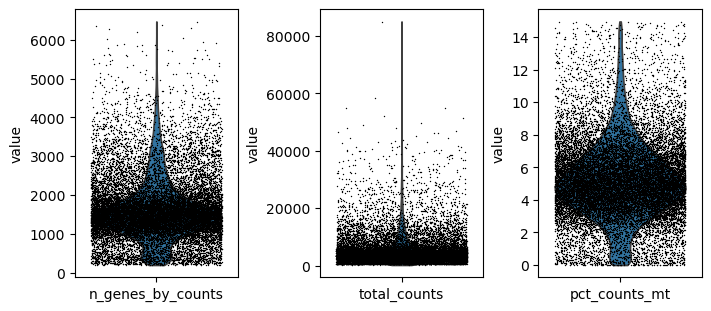

In [177]:
fig, axs = plt.subplots(1, 3, figsize=(7,3),constrained_layout=True)
sc.pl.violin(adata_GSE234129, ['n_genes_by_counts'], 
             jitter=0.4, ax=axs[0], show=False)
sc.pl.violin(adata_GSE234129, ['total_counts'],
             jitter=0.4, ax=axs[1], show=False)
sc.pl.violin(adata_GSE234129, ['pct_counts_mt'],
             jitter=0.4, ax=axs[2], show=False)

In [178]:
adata_GSE234129.X[1,].toarray().max()

24.0

In [179]:
adata_GSE234129.layers["counts"] = adata_GSE234129.X.copy()
sc.pp.normalize_total(adata_GSE234129, target_sum=1e4)
sc.pp.log1p(adata_GSE234129)
adata_GSE234129.layers["logcounts"] = adata_GSE234129.X.copy()

In [180]:
adata_GSE234129.X[1,].toarray().max()

5.8038646213928295

In [194]:
sc.pp.highly_variable_genes(
    adata_GSE234129, n_top_genes=3000, batch_key = "batch", flavor="seurat"
)

## Batch && Dimension reduction

In [14]:
adata_GSE234129 = sc.read_h5ad("Output/01/adata_GSE234129.h5ad")

In [15]:
adata_GSE234129

AnnData object with n_obs × n_vars = 19488 × 27176
    obs: 'nCount_RNA', 'nFeature_RNA'
    var: 'name'

In [12]:
adata2 = adata_GSE234129.copy()
adata2 = adata2[:, adata2.var.highly_variable]
sc.pp.regress_out(adata2, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata2, max_value=10)
sc.tl.pca(adata2, n_comps = 50)
sc.pp.neighbors(adata2, n_neighbors=30)
sc.tl.umap(adata2)

In [13]:
adata2.obsm["X_pca_raw"] = adata2.obsm["X_pca"]
adata2.obsm["X_umap_raw"] = adata2.obsm["X_umap"]

In [195]:
sc.tl.pca(adata_GSE234129, n_comps = 50)
sc.pp.neighbors(adata_GSE234129, n_neighbors=30)
sc.tl.umap(adata_GSE234129)

In [199]:
adata_GSE234129.obsm["X_pca_raw"] = adata_GSE234129.obsm["X_pca"]
adata_GSE234129.obsm["X_umap_raw"] = adata_GSE234129.obsm["X_umap"]

/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Unscaled'}, xlabel='X_umap_raw1', ylabel='X_umap_raw2'>

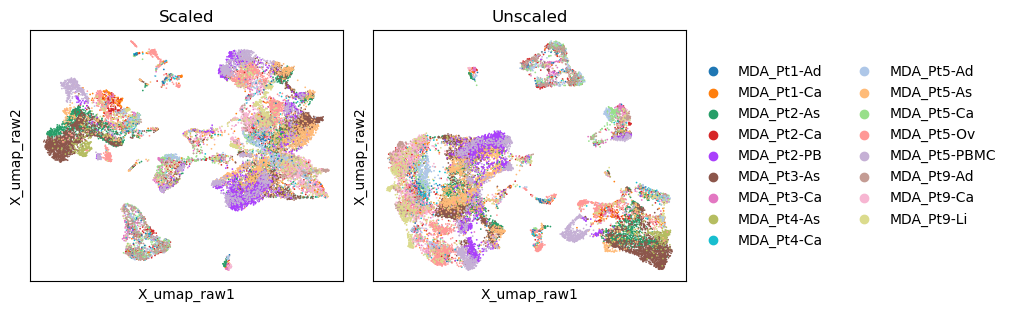

In [201]:
fig, axs = plt.subplots(1, 2, figsize=(10,3),constrained_layout=True)
sc.pl.embedding(adata2, color="batch", basis = "X_umap_raw", title="Scaled", ax=axs[0], show=False, legend_loc = None)
sc.pl.embedding(adata_GSE234129, color="batch", basis = "X_umap_raw", title="Unscaled", ax=axs[1], show=False)

In [14]:
sc.external.pp.harmony_integrate(adata2, key= "batch", basis='X_pca_raw')

2024-02-20 15:20:05,909 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


2024-02-20 15:20:14,898 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2024-02-20 15:20:15,109 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2024-02-20 15:20:21,374 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2024-02-20 15:20:27,030 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2024-02-20 15:20:32,845 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2024-02-20 15:20:38,524 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2024-02-20 15:20:44,359 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2024-02-20 15:20:49,186 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2024-02-20 15:20:53,267 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2024-02-20 15:20:57,809 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

In [15]:
sc.pp.neighbors(adata2, use_rep = "X_pca_harmony", n_neighbors=30)
sc.tl.umap(adata2)

In [205]:
sc.external.pp.harmony_integrate(adata_GSE234129, key= "batch", basis='X_pca_raw')

2024-01-29 15:43:37,620 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


2024-01-29 15:43:45,595 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-01-29 15:43:45,771 - harmonypy - INFO - Iteration 1 of 10
2024-01-29 15:43:50,821 - harmonypy - INFO - Iteration 2 of 10
2024-01-29 15:43:55,816 - harmonypy - INFO - Iteration 3 of 10
2024-01-29 15:44:00,918 - harmonypy - INFO - Iteration 4 of 10
2024-01-29 15:44:06,274 - harmonypy - INFO - Iteration 5 of 10
2024-01-29 15:44:10,181 - harmonypy - INFO - Converged after 5 iterations


In [206]:
sc.pp.neighbors(adata_GSE234129, use_rep = "X_pca_harmony", n_neighbors=30)
sc.tl.umap(adata_GSE234129)

In [207]:
adata2.obsm["X_umap_harmony"] = adata2.obsm["X_umap"]
adata_GSE234129.obsm["X_umap_harmony"] = adata_GSE234129.obsm["X_umap"]

/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Unscaled'}, xlabel='X_umap_harmony1', ylabel='X_umap_harmony2'>

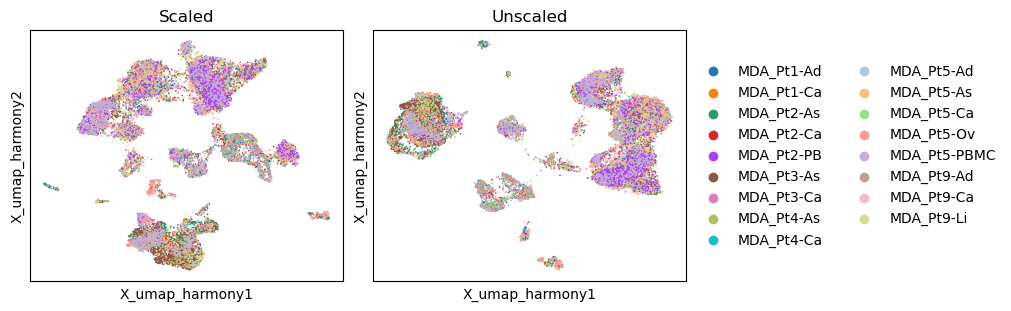

In [208]:
fig, axs = plt.subplots(1, 2, figsize=(10,3),constrained_layout=True)
sc.pl.embedding(adata2, color="batch", basis = "X_umap_harmony", title="Scaled", ax=axs[0], show=False, legend_loc = None)
sc.pl.embedding(adata_GSE234129, color="batch", basis = "X_umap_harmony", title="Unscaled", ax=axs[1], show=False)

/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Unscaled'}, xlabel='X_umap_harmony1', ylabel='X_umap_harmony2'>

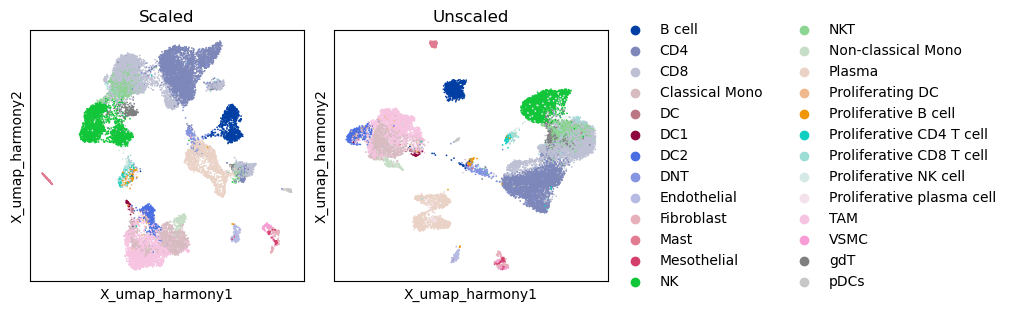

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10,3),constrained_layout=True)
sc.pl.embedding(adata2, color="final_celltype", basis = "X_umap_harmony", title="Scaled", ax=axs[0], show=False, legend_loc = None)
sc.pl.embedding(adata_GSE234129, color="final_celltype", basis = "X_umap_harmony", title="Unscaled", ax=axs[1], show=False)

## Save

In [ ]:
adata_GSE234129.obsm["X_umap_scaled_raw"] = adata2.obsm["X_umap_raw"]
adata_GSE234129.obsm["X_umap_scaled_harmony"] = adata2.obsm["X_umap_harmony"]

In [9]:
adata_GSE234129 = sc.read_h5ad("Output/01/adata_GSE234129.h5ad")

In [32]:
addEmbeddingData(adata_GSE234129, adata2)

In [41]:
adata_GSE234129.obs['ref_celltype'] = adata_GSE234129.obs['final_celltype']

In [35]:
adata_GSE234129.write_h5ad("Output/01/adata_GSE234129.h5ad", compression='gzip')

# GSE206785

## Prepare

In [ ]:
%%R
mtx <- fread(file = "../../processed_DB/GSE206785/GSE206785_scgex.txt.gz")
metadata <- fread(file = "../../processed_DB/GSE206785/GSE206785_metadata.txt.gz")

mtx.rownames <- mtx$Cell
mtx <- mtx[,-1]
mtx <- as.matrix(mtx)
rownames(mtx) <- mtx.rownames
mtx <- t(mtx)

seu_GSE206785 <- CreateSeuratObject(mtx)
metadata2 <- seu_GSE206785@meta.data
metadata2 <- cbind(metadata2, metadata)
seu_GSE206785@meta.data <- metadata2 

sceasy::convertFormat(seu_GSE206785, from="seurat", to="anndata",
                       outFile='Output/01/adata_GSE206785.h5ad')                                  

In [10]:
# adata_GSE206785 = sc.read_csv("../../processed_DB/GSE206785/GSE206785_scgex.txt.gz")
# labels_GSE206785 = pd.read_table('../../processed_DB/GSE206785/GSE206785_metadata.txt.gz')
# labels_GSE206785
# obs_names = adata_GSE206785.obs_names
# adata_GSE206785.obs = labels_GSE206785
# adata_GSE206785.obs_names = obs_names
# adata_GSE206785

In [57]:
adata_GSE206785 = sc.read_h5ad("Output/01/adata_GSE206785.h5ad")

In [58]:
adata_GSE206785

AnnData object with n_obs × n_vars = 111140 × 25287
    obs: 'nCount_RNA', 'nFeature_RNA', 'Sample', 'Patient', 'Tissue', 'Platform', 'Subtype', 'Type', 'Annotation'
    var: 'name'

## QC

In [66]:
basicQC(adata_GSE206785)

/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


<Axes: ylabel='value'>

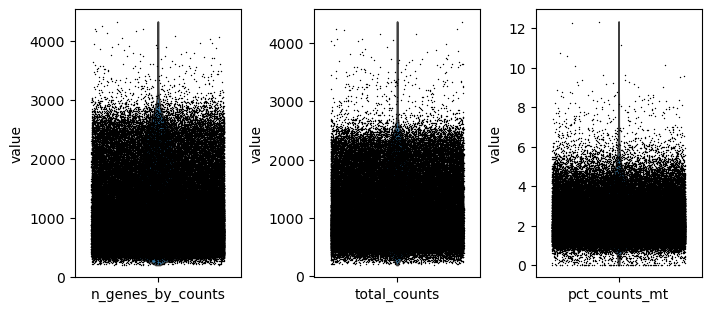

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(7,3),constrained_layout=True)
sc.pl.violin(adata_GSE206785, ['n_genes_by_counts'], 
             jitter=0.4, ax=axs[0], show=False)
sc.pl.violin(adata_GSE206785, ['total_counts'],
             jitter=0.4, ax=axs[1], show=False)
sc.pl.violin(adata_GSE206785, ['pct_counts_mt'],
             jitter=0.4, ax=axs[2], show=False)

## Batch && Dimension

In [65]:
adata_GSE206785

AnnData object with n_obs × n_vars = 111140 × 25287
    obs: 'nCount_RNA', 'nFeature_RNA', 'Sample', 'Patient', 'Tissue', 'Platform', 'Subtype', 'Type', 'Annotation'
    var: 'name'

Text(0.5, 1.0, 'Shifted logarithm')

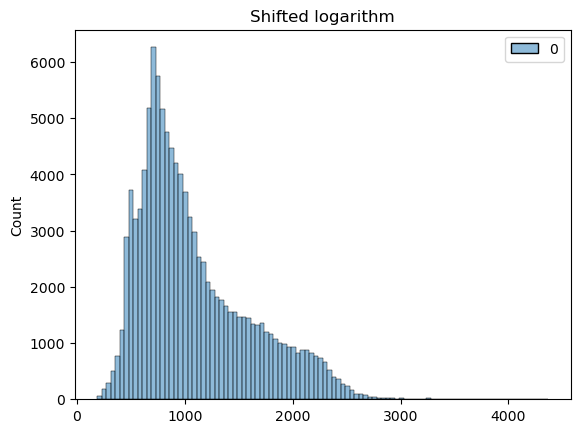

In [76]:
p1 = sns.histplot(adata_GSE206785.X.sum(1), bins=100, kde=False)
p1.set_title("Shifted logarithm")

Provided mtx is transformed.

In [80]:
adata_GSE206785 = normalizeData(adata_GSE206785, log = False, scale = False)

In [23]:
adata_GSE206785_scale_hvg = normalizeData(adata_GSE206785, log = False, scale = True)

In [84]:
adata_GSE206785_scale_hvg

AnnData object with n_obs × n_vars = 111109 × 3008
    obs: 'nCount_RNA', 'nFeature_RNA', 'Sample', 'Patient', 'Tissue', 'Platform', 'Subtype', 'Type', 'Annotation', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg'

In [88]:
adata_GSE206785.obs["Sample"].value_counts()

180308T    10885
181019N    10658
180124T     9212
181227N     5985
180124N     5870
180123N     5441
180606T     5077
180123T     4527
180118T     4296
190103N     3465
190118N     2996
190124N     2476
181025N     2373
181019T     2352
190124T     2348
181217T     2292
180608T     2126
171218T     1949
171116T     1947
171012T     1872
171218N     1841
190118T     1800
180118N     1614
180129T     1604
180116T     1604
180611T     1517
181227T     1492
190103T     1359
180605T     1320
181025T     1049
190123T      969
180129N      802
171116N      793
180608N      711
180611N      663
181026T      658
190125T      625
190123N      564
180308N      483
180305T      350
171012N      299
181217N      268
180116N      255
181026N      202
180605N       70
190125N       34
180606N       14
180305N        2
Name: Sample, dtype: int64

In [ ]:
dimensionReduction(adata_GSE206785)

In [24]:
adata_GSE206785_scale_hvg.obs["batch"] = adata_GSE206785_scale_hvg.obs["Sample"]
dimensionReduction(adata_GSE206785_scale_hvg)

2024-02-20 15:35:23,450 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2024-02-20 15:36:15,273 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2024-02-20 15:36:15,950 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2024-02-20 15:37:54,961 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2024-02-20 15:39:34,042 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2024-02-20 15:41:15,144 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2024-02-20 15:42:56,314 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2024-02-20 15:44:43,779 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2024-02-20 15:46:37,272 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2024-02-20 15:48:01,806 - 

/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Unscaled'}, xlabel='X_umap_raw1', ylabel='X_umap_raw2'>

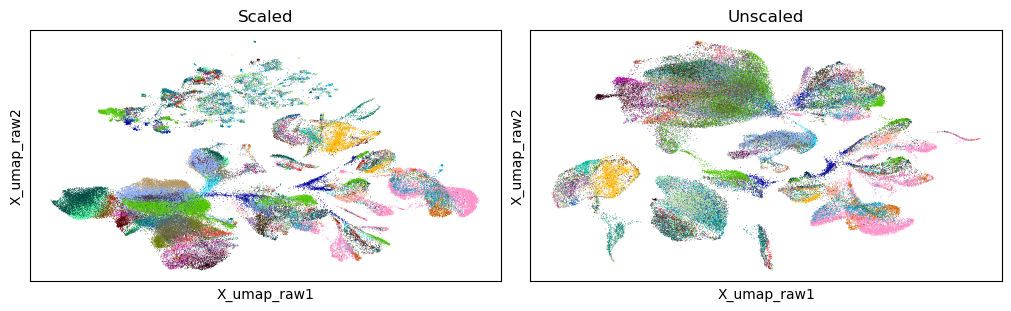

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(10,3),constrained_layout=True)
sc.pl.embedding(adata_GSE206785, color="batch", basis = "X_umap_raw", title="Scaled", ax=axs[0], show=False, legend_loc = None)
sc.pl.embedding(adata_GSE206785_scale_hvg, color="batch", basis = "X_umap_raw", title="Unscaled", ax=axs[1], show=False, 
                legend_loc = None)

/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Unscaled'}, xlabel='X_umap_harmony1', ylabel='X_umap_harmony2'>

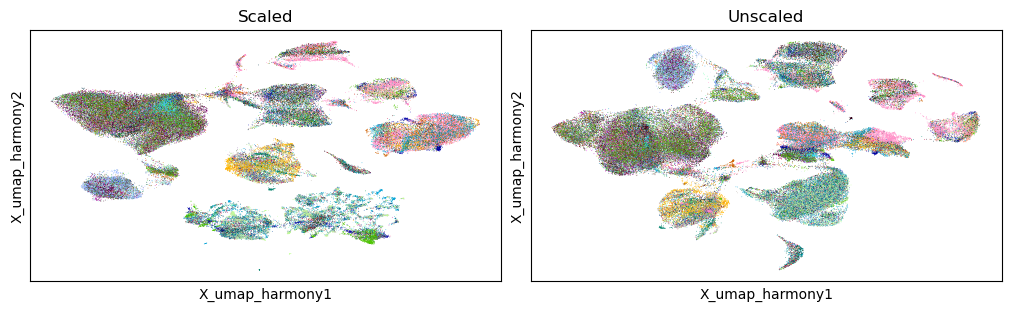

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(10,3),constrained_layout=True)
sc.pl.embedding(adata_GSE206785, color="batch", basis = "X_umap_harmony", title="Scaled", ax=axs[0], show=False, legend_loc = None)
sc.pl.embedding(adata_GSE206785_scale_hvg, color="batch", basis = "X_umap_harmony", title="Unscaled", ax=axs[1], show=False,
                 legend_loc = None)

In [106]:
adata_GSE206785.obs

,nCount_RNA,nFeature_RNA,Sample,Patient,Tissue,Platform,Subtype,Type,Annotation,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch
AAACCTGAGAGTACCG-1-171012N,752.546035,825,171012N,P171012,Normal,SC3P,P01,Plasma,P01_Plasma_IgAλ,825,825,752.546035,12.529894,1.665000,171012N
AAAGTAGCAAAGGTGC-1-171012N,224.320004,265,171012N,P171012,Normal,SC3P,P02,Plasma,P02_Plasma_IgAκ,265,265,224.320004,5.950643,2.652747,171012N
ACACCGGCACCAGTTA-1-171012N,404.421540,422,171012N,P171012,Normal,SC3P,P02,Plasma,P02_Plasma_IgAκ,422,422,404.421540,4.682131,1.157735,171012N
ACAGCTATCAAAGTAG-1-171012N,1331.384498,1472,171012N,P171012,Normal,SC3P,P02,Plasma,P02_Plasma_IgAκ,1472,1472,1331.384498,19.748803,1.483328,171012N
ACGCCAGAGAGTACCG-1-171012N,550.491735,556,171012N,P171012,Normal,SC3P,P01,Plasma,P01_Plasma_IgAλ,556,556,550.491735,12.838195,2.332132,171012N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCGACCATCAATCTCT-1-190124T,2549.192001,2664,190124T,P190124,Tumor,SC5P,B12,B,B12_Cycling_,2664,2664,2549.192001,20.165198,0.791043,190124T
GTATCTTTCTGACCTC-1-190124T,2996.685524,2953,190124T,P190124,Tumor,SC5P,B12,B,B12_Cycling_,2953,2953,2996.685524,35.986883,1.200890,190124T
TACAGTGTCGCAAACT-1-190124T,3097.907618,3079,190124T,P190124,Tumor,SC5P,B12,B,B12_Cycling_,3079,3079,3097.907618,28.170142,0.909328,190124T
TCGGTAATCATCACCC-1-190124T,3445.173468,3387,190124T,P190124,Tumor,SC5P,B12,B,B12_Cycling_,3387,3387,3445.173468,31.937831,0.927031,190124T


/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Scaled'}, xlabel='X_umap_harmony1', ylabel='X_umap_harmony2'>

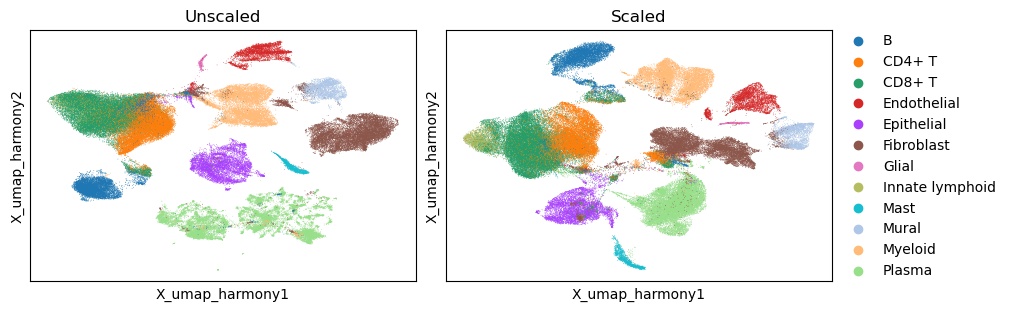

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10,3),constrained_layout=True)
sc.pl.embedding(adata_GSE206785, color="Type", basis = "X_umap_harmony", title="Unscaled", ax=axs[0], show=False, legend_loc = None)
sc.pl.embedding(adata_GSE206785_scale_hvg, color="Type", basis = "X_umap_harmony", title="Scaled", ax=axs[1], show=False)

## Save

In [108]:
adata_GSE206785.obsm["X_umap_scaled_raw"] = adata_GSE206785_scale_hvg.obsm["X_umap_raw"]
adata_GSE206785.obsm["X_umap_scaled_harmony"] = adata_GSE206785_scale_hvg.obsm["X_umap_harmony"]

In [10]:
adata_GSE206785 = sc.read_h5ad("Output/01/adata_GSE206785.h5ad")

In [42]:
adata_GSE206785.obs

,nCount_RNA,nFeature_RNA,Sample,Patient,Tissue,Platform,Subtype,Type,Annotation,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch
AAACCTGAGAGTACCG-1-171012N,752.546035,825,171012N,P171012,Normal,SC3P,P01,Plasma,P01_Plasma_IgAλ,825,825,752.546035,12.529894,1.665000,171012N
AAAGTAGCAAAGGTGC-1-171012N,224.320004,265,171012N,P171012,Normal,SC3P,P02,Plasma,P02_Plasma_IgAκ,265,265,224.320004,5.950643,2.652747,171012N
ACACCGGCACCAGTTA-1-171012N,404.421540,422,171012N,P171012,Normal,SC3P,P02,Plasma,P02_Plasma_IgAκ,422,422,404.421540,4.682131,1.157735,171012N
ACAGCTATCAAAGTAG-1-171012N,1331.384498,1472,171012N,P171012,Normal,SC3P,P02,Plasma,P02_Plasma_IgAκ,1472,1472,1331.384498,19.748803,1.483328,171012N
ACGCCAGAGAGTACCG-1-171012N,550.491735,556,171012N,P171012,Normal,SC3P,P01,Plasma,P01_Plasma_IgAλ,556,556,550.491735,12.838195,2.332132,171012N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCGACCATCAATCTCT-1-190124T,2549.192001,2664,190124T,P190124,Tumor,SC5P,B12,B,B12_Cycling_,2664,2664,2549.192001,20.165198,0.791043,190124T
GTATCTTTCTGACCTC-1-190124T,2996.685524,2953,190124T,P190124,Tumor,SC5P,B12,B,B12_Cycling_,2953,2953,2996.685524,35.986883,1.200890,190124T
TACAGTGTCGCAAACT-1-190124T,3097.907618,3079,190124T,P190124,Tumor,SC5P,B12,B,B12_Cycling_,3079,3079,3097.907618,28.170142,0.909328,190124T
TCGGTAATCATCACCC-1-190124T,3445.173468,3387,190124T,P190124,Tumor,SC5P,B12,B,B12_Cycling_,3387,3387,3445.173468,31.937831,0.927031,190124T


In [37]:
addEmbeddingData(adata_GSE206785, adata_GSE206785_scale_hvg)

In [43]:
adata_GSE206785.obs["ref_celltype"] = adata_GSE206785.obs["Type"]

In [44]:
adata_GSE206785.write_h5ad("Output/01/adata_GSE206785.h5ad", compression='gzip')

# Test scale and unscale performance

- Ref: [Benchmarking large-scale integration — scib-metrics](https://scib-metrics.readthedocs.io/en/stable/notebooks/large_scale.html)

In [6]:
from scib_metrics.benchmark import Benchmarker

In [ ]:
adata_stanford = sc.read_h5ad("Output/01/adata_stanford.h5ad")

/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
adata_stanford

AnnData object with n_obs × n_vars = 36159 × 33538
    obs: 'batch', 'database', 'barcode', 'condition', 'final_celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'ref_celltype'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'batch_colors', 'final_celltype_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_harmony_scaled', 'X_pca_harmony_unscaled', 'X_pca_raw', 'X_pca_raw_scaled', 'X_pca_raw_unscaled', 'X_umap', 'X_umap_harmony', 'X_umap_harmony_scaled', 'X_umap_harmony_unscaled', 'X_umap_raw', 'X_umap_raw_scaled', 'X_umap_raw_unscaled', 'X_umap_scaled_harmony', 'X_umap_scaled_raw'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'connectivities', 'distances'

Stanford

/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/pengyz/miniconda3/envs/sc_py3/lib/python3.11/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
Embeddings: 100%|██████████| 4/4 [08:54<00:00, 133.55s/it]


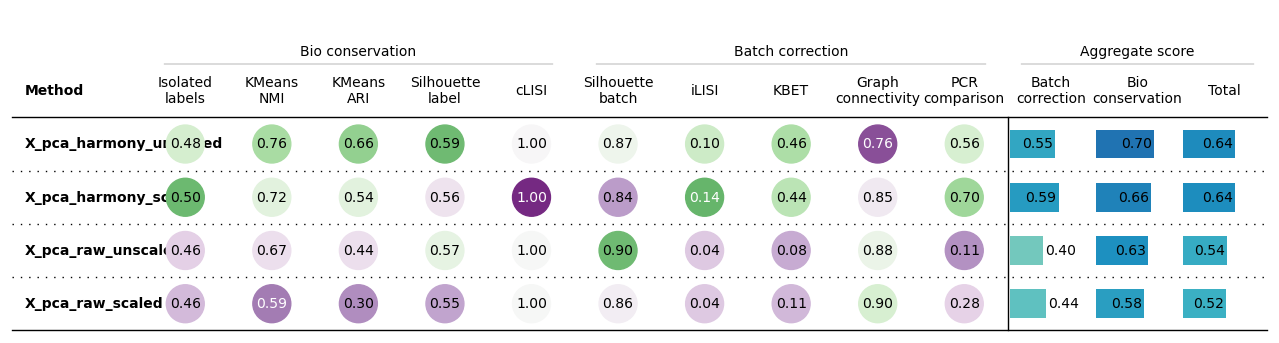

In [8]:
bm = Benchmarker(
    adata_stanford,
    batch_key="batch",
    label_key="ref_celltype",
    embedding_obsm_keys=["X_pca_raw_scaled", "X_pca_raw_unscaled",
                         "X_pca_harmony_scaled", "X_pca_harmony_unscaled"],
    n_jobs=72,
)
bm.benchmark()
bm.plot_results_table(min_max_scale=False)

GSE234129

Embeddings: 100%|██████████| 4/4 [03:36<00:00, 54.18s/it]


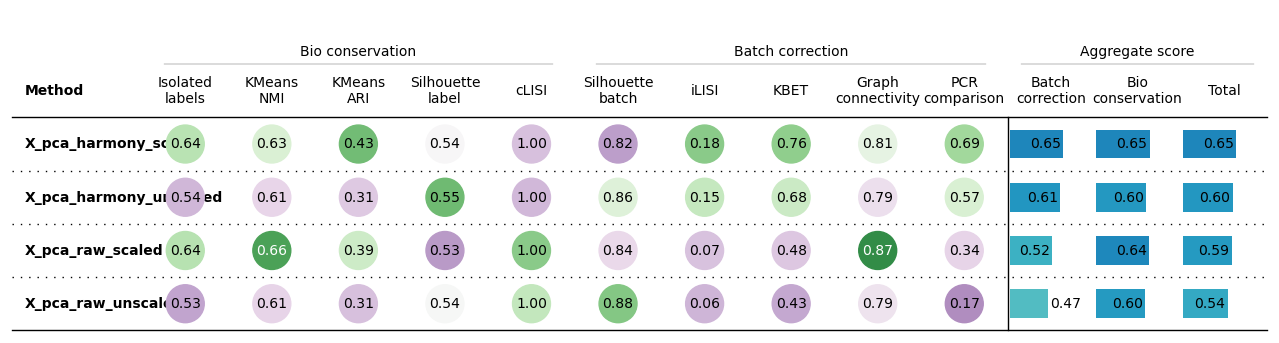

In [45]:
bm2 = Benchmarker(
    adata_GSE234129,
    batch_key="batch",
    label_key="ref_celltype",
    embedding_obsm_keys=["X_pca_raw_scaled", "X_pca_raw_unscaled",
                         "X_pca_harmony_scaled", "X_pca_harmony_unscaled"],
    n_jobs=72,
)
bm2.benchmark()
bm2.plot_results_table(min_max_scale=False)

GSE206785

Embeddings: 100%|██████████| 4/4 [1:15:26<00:00, 1131.59s/it]


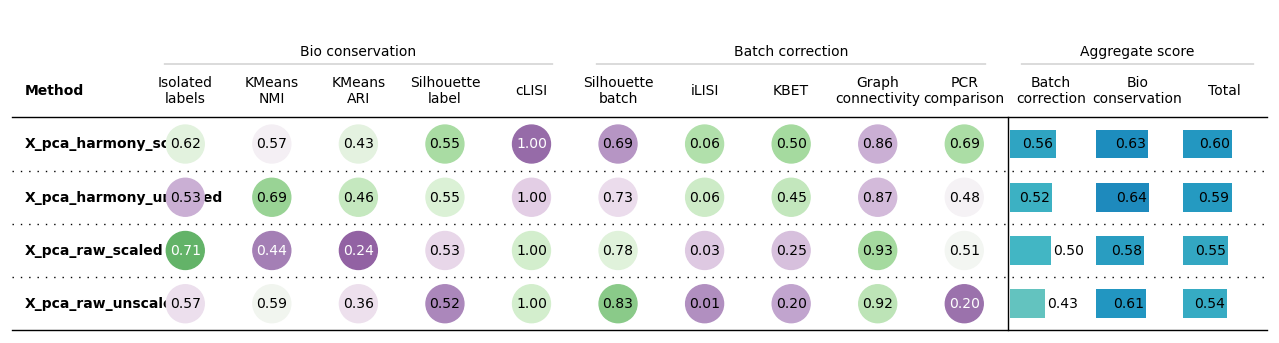

In [46]:
bm3 = Benchmarker(
    adata_GSE206785,
    batch_key="batch",
    label_key="ref_celltype",
    embedding_obsm_keys=["X_pca_raw_scaled", "X_pca_raw_unscaled",
                         "X_pca_harmony_scaled", "X_pca_harmony_unscaled"],
    n_jobs=72,
)
bm3.benchmark()
bm3.plot_results_table(min_max_scale=False)

# Others

In [ ]:
adata.obs.to_csv